<a id='К_оглавлению'></a>
# Описание проекта

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

---

### Описание данных

* **id** — уникальный идентификатор скважины;
* **f0, f1, f2** — три признака точек (неважно, что они означают, но сами признаки значимы);
* **product** — объём запасов в скважине (тыс. баррелей).

### Разделим исследование на несколько частей

1. [Загрузка библиотек и подготовка данных](#Загрузка_библиотек_и_подготовка_данных) 
 * 1.1 Загрузка библиотек.
 * 1.2 Разделение данных на выборки.
2. [Обучение и проверка модели](#Обучение_и_проверка_модели)
 * 2.1 Обучение моделей
 * 2.2 Сбор результатов
3. [Подготовка к расчёту прибыли](#Подготовка_к_расчёту_прибыли)
4. [Расчёт прибыли и рисков](#Расчёт_прибыли_и_рисков)


---
<a id='Загрузка_библиотек_и_подготовка_данных'></a>
# 1. Загрузка и подготовка данных
Загрузим необходимые бибилиотеки и посмотрим на таблицы.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

data_one = pd.read_csv('/datasets/geo_data_0.csv')
data_two = pd.read_csv('/datasets/geo_data_1.csv')
data_three = pd.read_csv('/datasets/geo_data_2.csv')

In [2]:
data_one

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
...,...,...,...,...,...
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346843
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764


In [3]:
data_two

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
...,...,...,...,...,...
99995,QywKC,9.535637,-6.878139,1.998296,53.906522
99996,ptvty,-10.160631,-12.558096,5.005581,137.945408
99997,09gWa,-7.378891,-3.084104,4.998651,137.945408
99998,rqwUm,0.665714,-6.152593,1.000146,30.132364


In [4]:
data_three

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
...,...,...,...,...,...
99995,4GxBu,-1.777037,1.125220,6.263374,172.327046
99996,YKFjq,-1.261523,-0.894828,2.524545,138.748846
99997,tKPY3,-1.199934,-2.957637,5.219411,157.080080
99998,nmxp2,-2.419896,2.417221,-5.548444,51.795253


Рзаделим таблицы на фичи и таргет

In [5]:
def f_t(df_name):
    feat_name = df_name.drop(['id','product'],axis=1)
    targ_name = df_name['product']
    return feat_name, targ_name

In [6]:
first_features, first_target = f_t(data_one)
second_features, second_target = f_t(data_two)
third_features, third_target = f_t(data_three)

Рзадилим таблицы на тренировочную и валидационную выборки.

In [7]:
f_features_train, f_features_valid, f_target_train, f_target_valid = train_test_split(
    first_features, first_target,train_size=0.75, random_state=42)

s_features_train, s_features_valid, s_target_train, s_target_valid = train_test_split(
    second_features, second_target, train_size=0.75, random_state=42)

t_features_train, t_features_valid, t_target_train, t_target_valid = train_test_split(
    third_features, third_target, train_size=0.75, random_state=42)

## Вывод
Были загружены необходимые библиотеки, данные разделены на выборки.

[К оглавлению](#К_оглавлению)

---

<a id='Обучение_и_проверка_модели'></a>
# 2. Обучение и проверка модели
Автоматизируем обучение моделей и обучим модели.

In [8]:
def model_train(features_train, features_valid, target_train, target_valid):
    model = LinearRegression()
    model.fit(features_train, target_train)
    prediction_valid = model.predict(features_valid)
    rmse = mean_squared_error(target_valid, prediction_valid)**0.5
    
    return  model, prediction_valid, rmse

#### Модель первого региона

In [9]:
model_one, prediction_valid_one, first_rmse = model_train(f_features_train, f_features_valid, 
                                                          f_target_train, f_target_valid)

#### Модель второго региона

In [10]:
model_two, prediction_valid_two, second_rmse = model_train(s_features_train, s_features_valid, 
                                                           s_target_train, s_target_valid)

#### Модель третьего региона

In [11]:
model_three, prediction_valid_three, third_rmse = model_train(t_features_train, t_features_valid, 
                                                              t_target_train, t_target_valid)

Посмотрим на *RMSE* и *среднее значение* моделей.

In [12]:
regions = pd.DataFrame({'Модель первого региона':[first_rmse, prediction_valid_one.mean()],
             'Модель второго региона': [second_rmse, prediction_valid_two.mean()],
             'Модель третьего региона':[third_rmse, prediction_valid_three.mean()]}, index=['RMSE', 'Среднее значение'])
regions

,Модель первого региона,Модель второго региона,Модель третьего региона
RMSE,37.7566,0.890280,40.145872
Среднее значение,92.3988,68.712878,94.771024


## Вывод
Модели для всех регионов были обучены. Самое низкое значение RMSE у второго региона, модель 2 региона практически не ошибается, в то время как модели первого и третьего региона ошибаются приблизительно на 40 едениц сырья. Средние значения у регионов зеркально RMSE, у первого и третьего региона оно выше. Среднее значение второго региона ниже.

[К оглавлению](#К_оглавлению)

---
<a id='Подготовка_к_расчёту_прибыли'></a>
# 3. Подготовка к расчёту прибыли

Вычислим минимальный порог для безубыточной разработки скважин(10млн-бюджет, 200-необходимое количество скважин, 450тыс-доход за единицу продукта).

In [13]:
TOTAL_BUD = 10e9
SEARCH_PL = 500
NEEDED_PL = 200 
BAR_PRICE = 450000

In [14]:
ONE_PLACE = TOTAL_BUD / NEEDED_PL
ONE_PLACE

50000000.0

In [15]:
TRESOLD = ONE_PLACE/BAR_PRICE
TRESOLD

111.11111111111111

Минимальное значние скважины должно привышать 111 едениц продукта, что бы разаработка была безубыточной. Сравним со средними значениями в регионах.

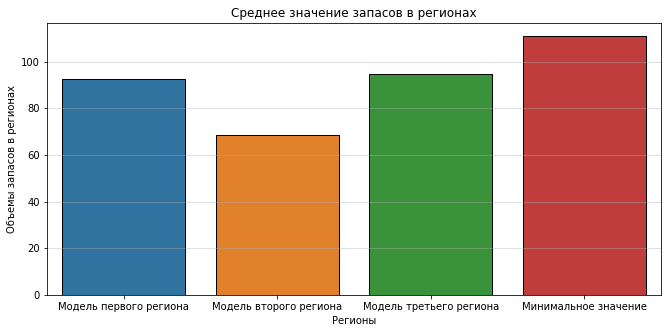

In [16]:
reg = regions.iloc[1].append(pd.DataFrame({0:111},index=["Минимальное значение"]))

plt.figure(figsize=(11,5))
plt.grid(alpha=0.5)
sns.barplot(x=reg.index, y=reg.loc[:,0],linewidth=1, edgecolor='black')
plt.xlabel('Регионы', fontsize=10)
plt.ylabel('Объемы запасов в регионах', fontsize=10)
plt.title('Среднее значение запасов в регионах')
plt.show()

## Вывод
Было вычеслино минимальное количество сырья, для безубыточной разработки скважин. Средние значения запасов в регионах ниже, чем необходимое минимальное значение для разработки.

[К оглавлению](#К_оглавлению)

---
<a id='Расчёт_прибыли_и_рисков'></a>
# 4. Расчёт прибыли и рисков 
Применим технуку `bootstrap` с 1000 выборок, чтобы найти 95% доверительный интервал, а так же рачситать прибыль и риски.

Создадим функцию, которая случайным образом выбирает 500 скважин и выбирает 200 из них. После вычисляет читую прибыль с этих скважин.

In [17]:
prediction_valid_one

array([101.90101715,  78.21777385, 115.26690103, ...,  82.54439653,
        81.82668931,  93.12106221])

In [18]:
def profit(target, pred):
    
    pred_sorted = pred.sort_values(ascending=False)    
    selected = target[pred_sorted.index][:200]
    
    return sum(selected*BAR_PRICE) - TOTAL_BUD

Создадим фунцию, которая испотльзует технику `bootstrap` и выдает доверительный интервал, среднее значение и риски.

In [19]:
state = np.random.RandomState(12345)

def boot(target_valid, prediction_valid):
        
    values = []
    for i in range(1000):
        prediction_ser = pd.Series(prediction_valid)
        prediction_ser.index = target_valid.index
        target_subsample = target_valid.sample(500, random_state=state, replace=True)
        probs_subsample = prediction_ser[target_subsample.index]
        values.append(profit(target_subsample, probs_subsample))         
               
    values=pd.Series(values)
    
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    mean = values.mean()/1000000
    risk = (values<0).mean()*100
    return lower, upper, mean, risk
    return probs_subsample

In [20]:
l_first, u_first, m_first, r_first = boot(f_target_valid, prediction_valid_one)

l_second, u_second, m_second, r_second = boot(s_target_valid, prediction_valid_two)

l_third, u_third, m_third, r_third = boot(t_target_valid, prediction_valid_three)

In [21]:
pd.DataFrame({'Регионы':['geo_0', 'geo_1', 'geo_2'],
              'Среднее значение(млн)':[m_first, m_second, m_third],
             '95% Доверительный интервал':[(l_first, u_first), (l_second, u_second), (l_third, u_third)],
             'Риски %': [r_first, r_second, r_third]})

,Регионы,Среднее значение(млн),95% Доверительный интервал,Риски %
0,geo_0,435.933772,"(-116231612.7772025, 966504180.7073855)",6.1
1,geo_1,498.569017,"(75315573.08896637, 911503695.024533)",1.0
2,geo_2,412.672899,"(-158939515.76361042, 978191201.7001914)",7.0


## Вывод 
Для разарботаки лучше выбрать **"geo_1"**. У этого региона риски ниже и среднее значение выше чем у других регионов, а доверительный интеврал уже.


[К оглавлению](#К_оглавлению)